In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, cross_val_predict, GridSearchCV, train_test_split)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve
sns.set_style('whitegrid')
DATA_PATH = Path('..', 'data')
house_sales = pd.read_csv('kc_house_data.csv')
house_sales = house_sales.drop(['id', 'zipcode', 'lat', 'long', 'date'], axis=1)

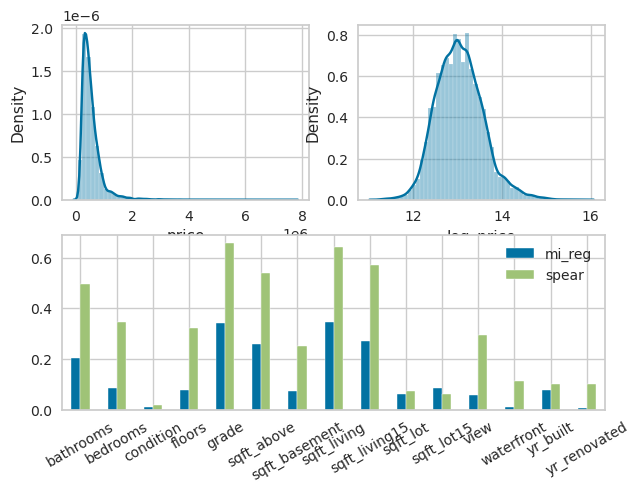

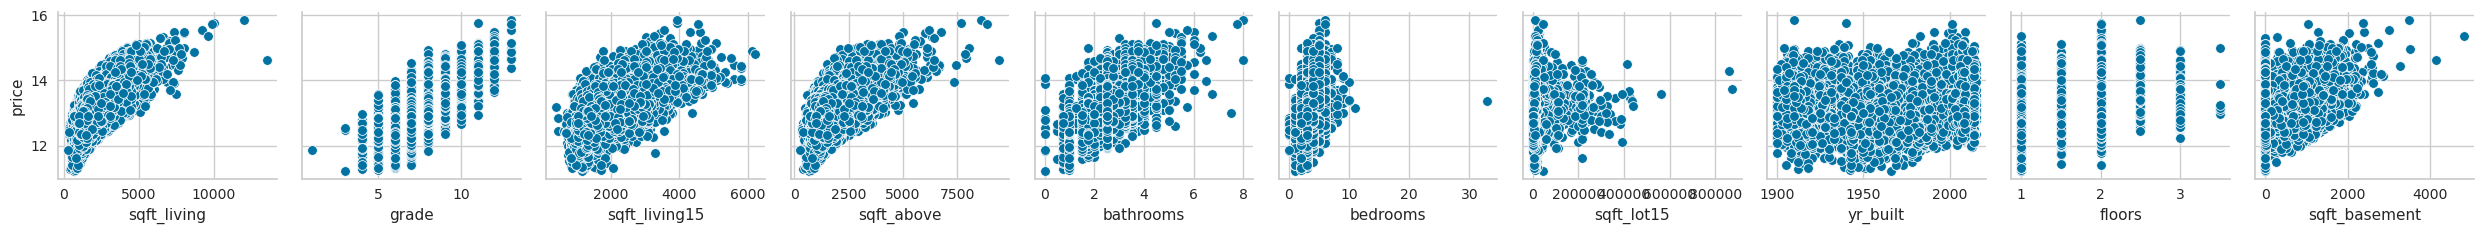

In [3]:
## step1 预处理label
prices = house_sales.assign(log_price=np.log(house_sales.price))
X_all = house_sales.drop('price', axis=1)
y = prices.log_price

f = plt.figure(figsize=(7, 5))
f.add_subplot(2,2,1)
sns.distplot(prices.price)
f.add_subplot(2,2,2)
sns.distplot(prices.log_price)

## step2-1 筛选特征；pearson线性关系，spearman单调关系，mutual_info任何关系
mi_coe = pd.Series(mutual_info_regression(X_all, y), index=X_all.columns).sort_values(ascending=False)
spear_coe = X_all.apply(lambda x: spearmanr(x, y)[0]).sort_values()

ax = f.add_subplot(2,1,2) #注意这种不均分的图，需要用ax指定
coes = pd.DataFrame({'mi_reg':mi_coe, 'spear':spear_coe}) #为啥线性关系，比互信息系数大这么多？
coes.plot.bar(rot=30, ax=ax) # barh()水平着画; 单独画一个图时可用figsize=(7, 3)指定大小
X = X_all.loc[:, mi_coe.iloc[:10].index]

## step2=2 筛选特征：结果可视化；pairplot貌似不能指定子图？？
sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)

sns.despine()
plt.tight_layout();

In [4]:
all_data = X.assign(y=y)
train_data, test_data = train_test_split(all_data, train_size=.8)

train_x = train_data.drop(['y'], axis=1)
train_y = train_data.y
test_x = test_data.drop(['y'], axis=1)
test_y = test_data.y

std_scaler = StandardScaler()
std_scaler.fit(train_x)
norm_train_x = std_scaler.transform(train_x)
norm_test_x = std_scaler.transform(test_x)
#xx = train_X.apply(['mean', 'std'])
#mean = train_X.mean()
#std = train_X.std()
#normed_X = X.sub(mean).divide(std)
#normed_test_X = test_X.sub(mean).divide(std)

In [5]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

## step3 默认超参下模型的表现
model = KNeighborsRegressor()
vanilla_pred = model.fit(X=norm_train_x, y=train_y).predict(norm_test_x)
vanilla_error = (test_y - vanilla_pred).rename('vanilla prediction Errors')

## step4 使用交叉验证优化超参；比step3多了交叉验证 + 超参选择
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))
rmse_score = make_scorer(rmse)

'''
sklearn.model_selection.cross_validate
    Evaluate metric(s) by cross-validation and also record fit/score times.
cross_val_score
    Run cross-validation for single metric evaluation.
cross_val_predict
    Get predictions from each split of cross-validation for diagnostic purposes.
sklearn.metrics.make_scorer
    Make a scorer from a performance metric or loss function
'''

cv_rmses = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=n))])  #z = (x - u) / s
    #分类问题调用StratifiedKFold(cv)，其他问题调用KFold(cv)，KFold(cv)表示数据等分cv份，进行cv次交叉验证
    cv_rmses[n] = cross_val_score(pipe, X=train_x, y=train_y, scoring=rmse_score, cv=5, n_jobs=-1)

cv_rmses = pd.DataFrame.from_dict(cv_rmses, orient='index')
best_n, best_rmse = cv_rmses.mean(1).idxmin(), cv_rmses.mean(1).min()
cv_rmses = cv_rmses.stack().reset_index() # 为了画lineplot
cv_rmses.columns =['neighbors', 'fold', 'RMSE']

## step5 交叉验证最优超参，构建模型
model_opt = KNeighborsRegressor(n_neighbors=best_n)
opt_pred = model_opt.fit(X=norm_train_x, y=train_y).predict(norm_test_x)
opt_error = (test_y - opt_pred).rename('opt prediction Errors')

pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=best_n))])
cv_pred = cross_val_predict(pipe, train_x, train_y, cv=5, n_jobs=-1)
cv_error = (train_y - cv_pred).rename('cv prediction Errors')

vanilla_rmse = np.sqrt(mean_squared_error(y_true=test_y, y_pred=vanilla_pred))
opt_rmse=np.sqrt(mean_squared_error(y_true=test_y, y_pred=opt_pred))
cv_rmse = np.sqrt(mean_squared_error(y_true=train_y, y_pred=cv_pred)) #和上2个指标不太可比

vanilla rmse=0.319, opt_rmse=0.307, cv_rmse=0.305


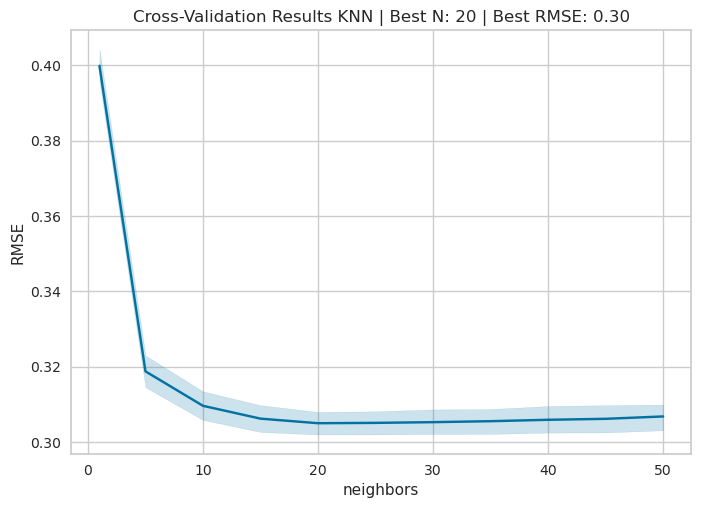

In [6]:
## step6-1 交叉验证中间指标; lineplot相同x可取不同y，实线表y的估计、上下虚影区表示估计的置信区间
## 交叉验证得到的最有超参，还没默认参数好？
print(f'vanilla rmse={vanilla_rmse:.3f}, opt_rmse={opt_rmse:.3f}, cv_rmse={cv_rmse:.3f}')

ax = sns.lineplot(x='neighbors', y='RMSE', data=cv_rmses)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');

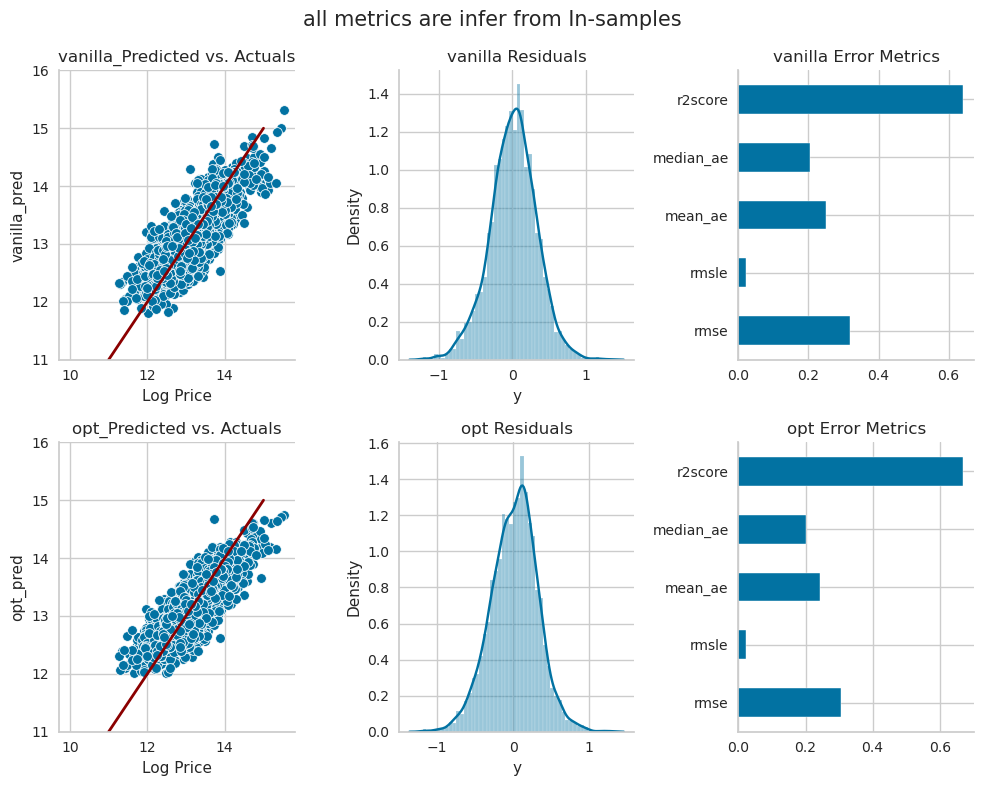

In [7]:
## step6-2 各步骤结果可视化
errors = []
scores = []
preds = [vanilla_pred, opt_pred]
for pred in preds:
    errors.append(test_y - pred)
    scores.append(dict(rmse=np.sqrt(mean_squared_error(y_true=test_y, y_pred=pred)),
                        rmsle=np.sqrt(mean_squared_log_error(y_true=test_y, y_pred=pred)),
                        mean_ae=mean_absolute_error(y_true=test_y, y_pred=pred),
                        median_ae=median_absolute_error(y_true=test_y, y_pred=pred),
                        r2score=explained_variance_score(y_true=test_y, y_pred=pred)))

y_range = list(range(int(test_y.min()-1), int(test_y.max()+1)))
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
fig.suptitle('all metrics are infer from In-samples', fontsize=15)
for idx, name in enumerate(['vanilla', 'opt']):
    axes[idx][0].set_title(f'{name}_Predicted vs. Actuals')
    axes[idx][0].set_xlabel('Log Price')
    axes[idx][0].set_ylabel(f'{name}_pred')
    axes[idx][0].set_ylim(11, 16)
    pd.Series(y_range, index=y_range).plot(lw=2, c='darkred', ax=axes[idx][0])
    sns.scatterplot(x=test_y, y=preds[idx], ax=axes[idx][0])
    
    axes[idx][1].set_title(f'{name} Residuals')
    sns.distplot(errors[idx], ax=axes[idx][1])
    #只有原生的画图api才可以指定title
    pd.Series(scores[idx]).plot.barh(ax=axes[idx][2], title=f'{name} Error Metrics')

sns.despine()
fig.tight_layout()
#plt.subplots_adjust(top=.8);

In [8]:
#pipe = Pipeline([('scaler', StandardScaler()),  ('knn', KNeighborsRegressor())])
#pd.set_option('display.max_columns', None) #显示所有列
#pd.set_option('display.max_rows', None)    #显示所有行
#pd.set_option('display.width', None)       #显示宽度无限长

# step7 更专业的超参搜索
n_folds = 5
n_neighbors = tuple(range(5, 101, 5))
param_grid = {'knn__n_neighbors': n_neighbors}
estimator = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=n_folds, scoring=rmse_score, n_jobs=-1)
estimator.fit(X=train_x, y=train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=20))]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

In [9]:
grid_opt_neighbors = estimator.best_params_['knn__n_neighbors']
cv_results = estimator.cv_results_
cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

(20, 0.3049830429189934)

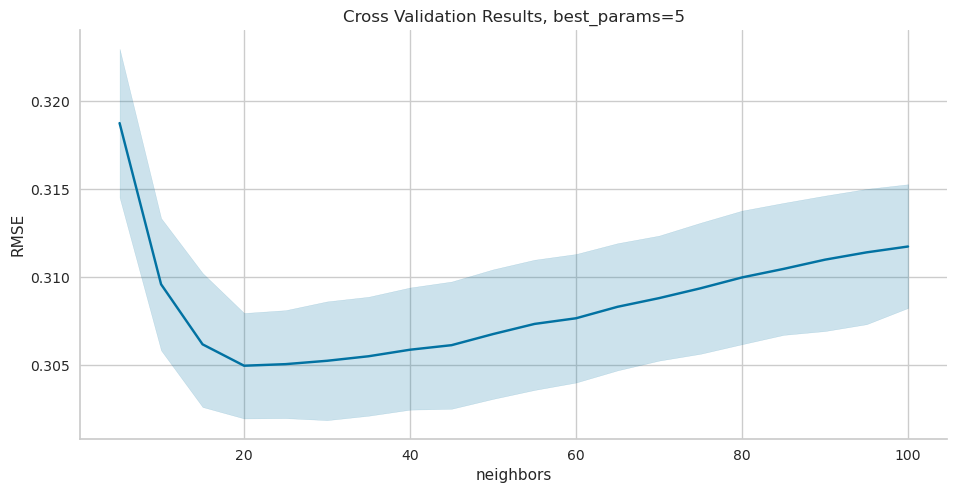

In [11]:
test_scores = {fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)}
test_scores = pd.DataFrame(test_scores, index=n_neighbors).stack().reset_index()
test_scores.columns = ['neighbors', 'fold', 'RMSE']
mean_rmse = test_scores.groupby('neighbors').RMSE.mean() #RMSE为test_scores中的RMSE列
best_n, best_score = mean_rmse.idxmin(), mean_rmse.min()
#sns.pointplot(x='neighbors', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
sns.lineplot(x='neighbors', y='RMSE', data=test_scores)
plt.title(f'Cross Validation Results, best_params={grid_opt_neighbors}')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);
best_n, best_score

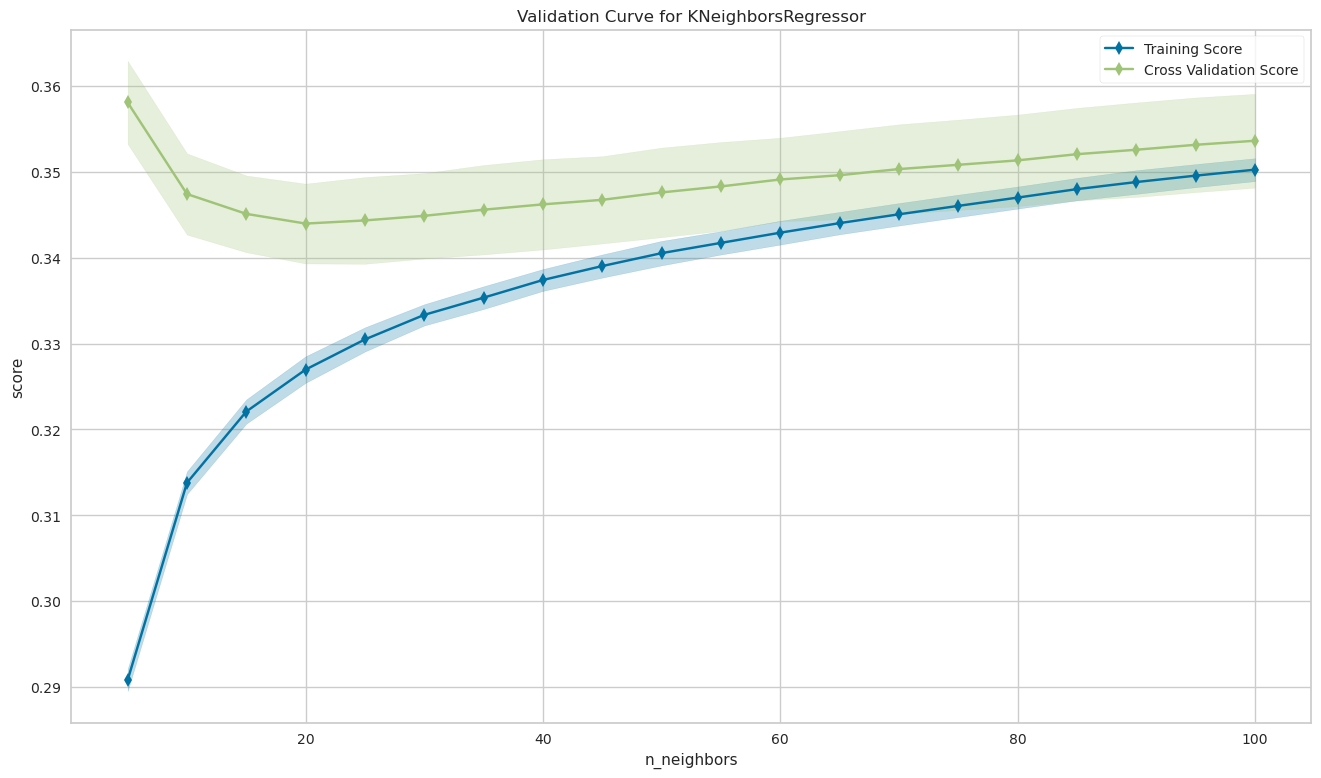

<Figure size 800x550 with 0 Axes>

In [12]:
#step8 训练过程可视化；ValidationCurve可以搜参，LearningCurve一般用搜参结果指定具体参数
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(), param_name='n_neighbors',
                            param_range=n_neighbors, cv=5, scoring=rmse_score, ax=ax, n_jobs=-1)
val_curve.fit(train_x, train_y)
val_curve.poof()
sns.despine()
fig.tight_layout();

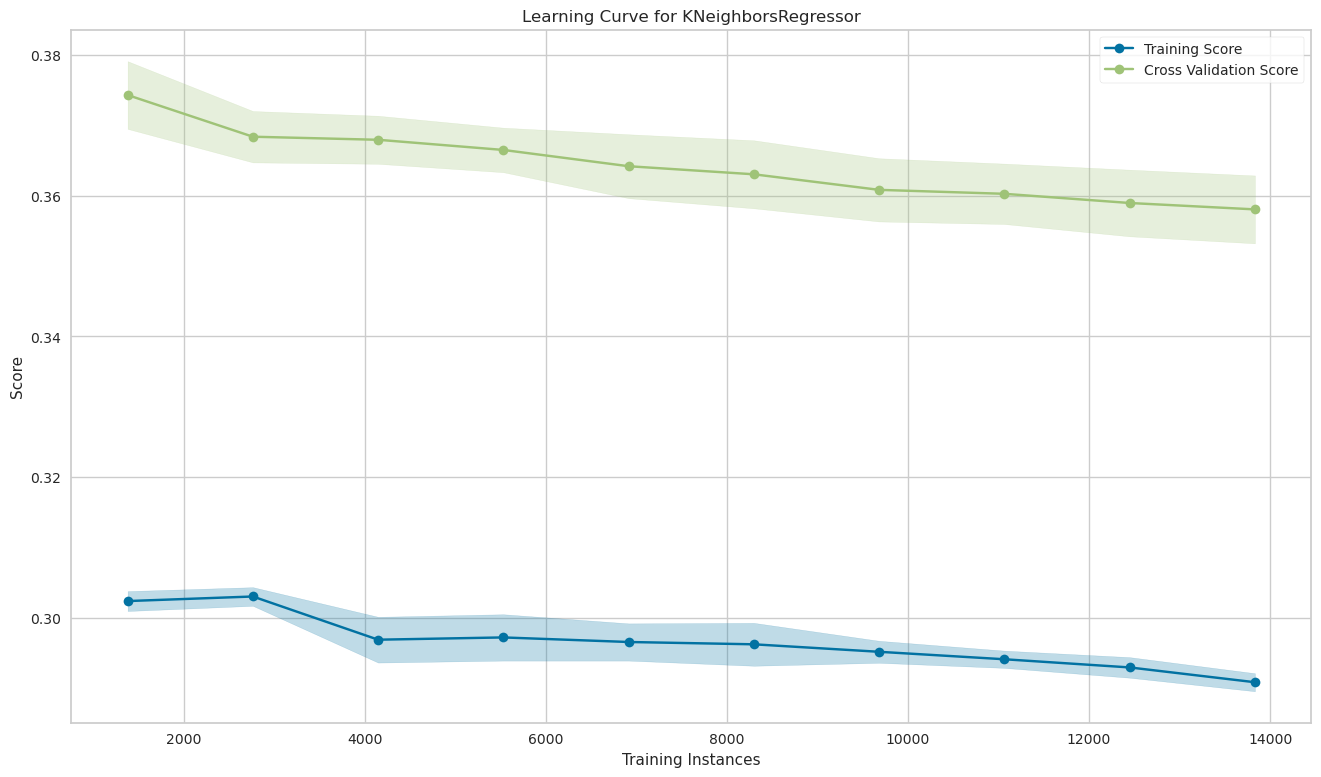

<Figure size 800x550 with 0 Axes>

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=grid_opt_neighbors), train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score, cv=5, ax=ax, n_jobs=-1)
l_curve.fit(train_x, train_y)
l_curve.poof()
sns.despine()
fig.tight_layout();

In [18]:
y_binary = (train_y > train_y.median()).astype(int)
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5

pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': n_neighbors}
estimator = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=n_folds, scoring='roc_auc', n_jobs=-1)
estimator.fit(X=train_x, y=y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

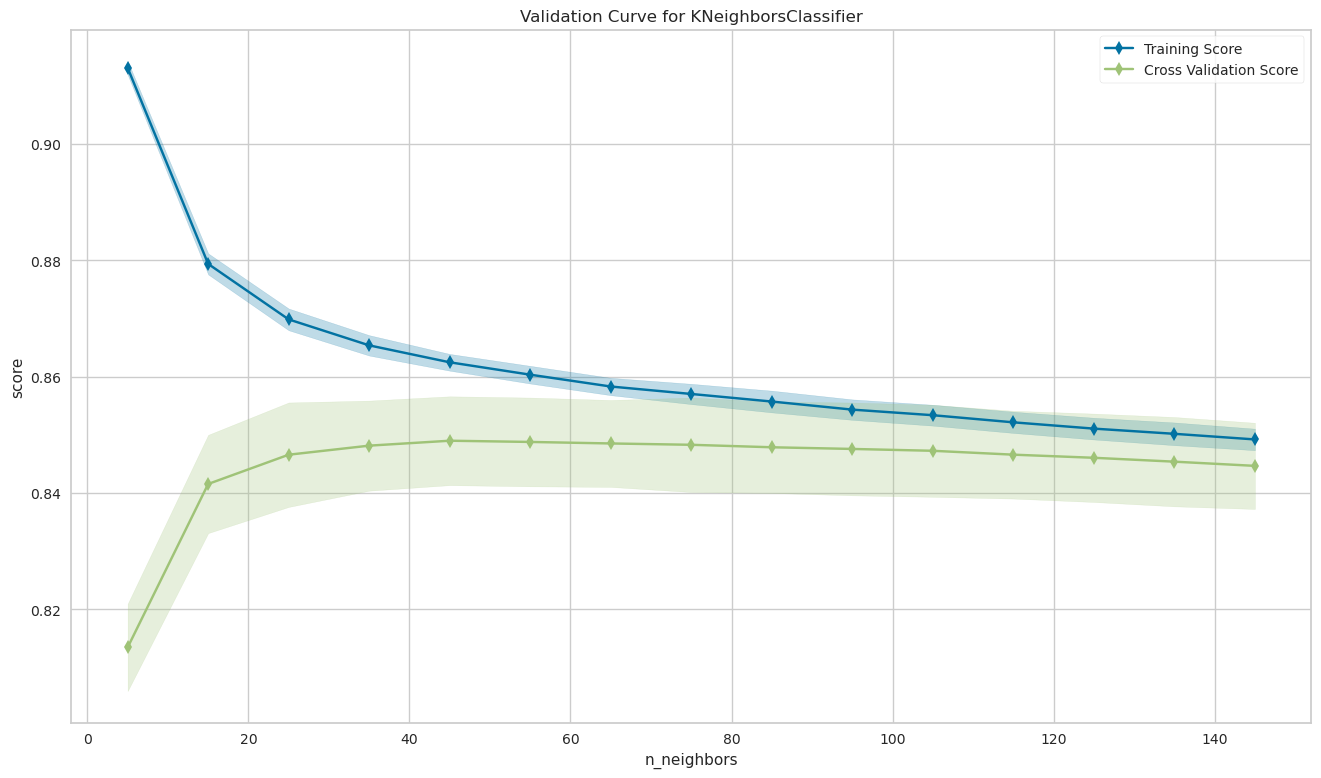

<Figure size 800x550 with 0 Axes>

In [22]:
best_k = estimator.best_params_['knn__n_neighbors']
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(), param_name='n_neighbors', param_range=n_neighbors,
                              cv=n_folds, scoring='roc_auc', ax=ax, n_jobs=-1)
val_curve.fit(train_x, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout();

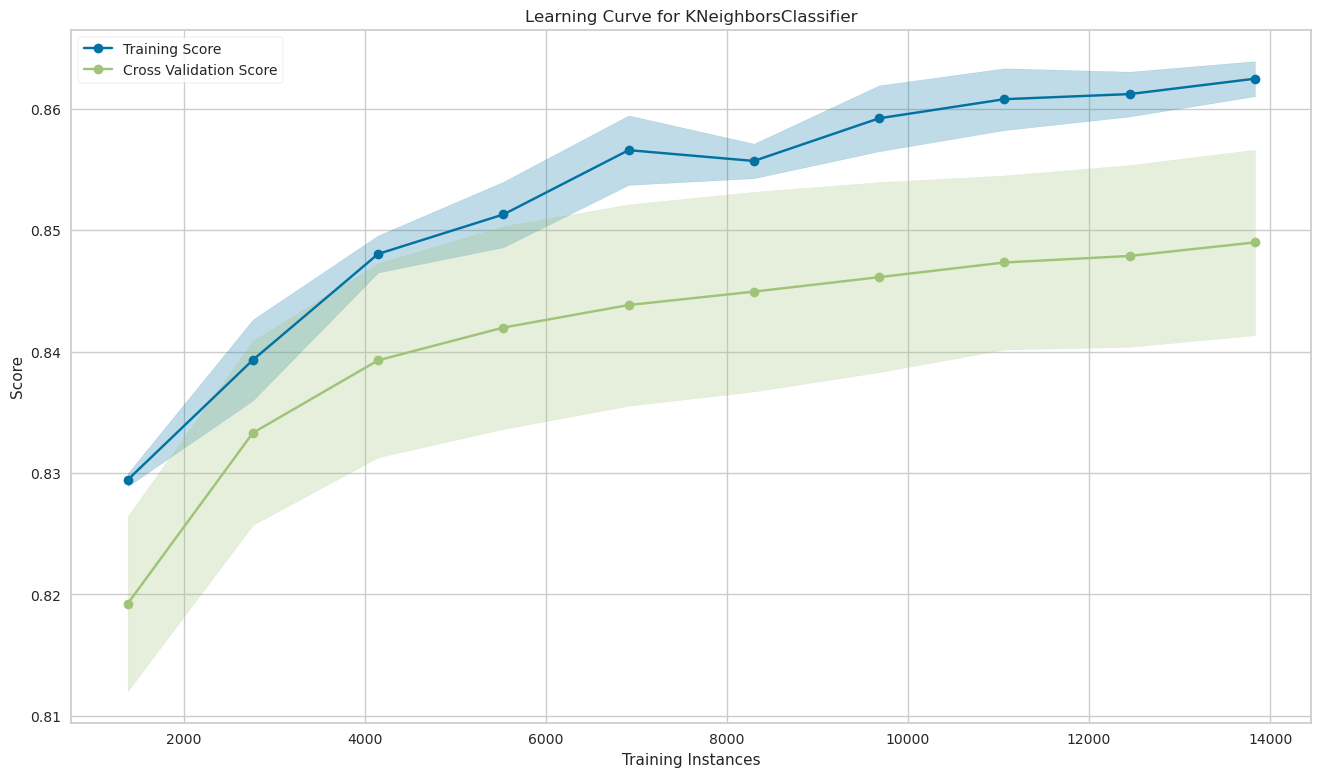

<Figure size 800x550 with 0 Axes>

In [24]:
best_k
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k),  train_sizes=np.arange(.1, 1.01, .1),
                        scoring='roc_auc', cv=5, ax=ax, n_jobs=-1)
l_curve.fit(train_x, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout();